In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings

import gc

import dask
import dask.dataframe as dd
from dask_cuda import LocalCUDACluster
from dask.distributed import Client, LocalCluster

#setting GPU & CPU multiple cores (the last one just with dask or other distributed packages)
"""cluster = LocalCluster(threads_per_worker=5,
                n_workers=8, memory_limit='auto')"""
cluster = LocalCluster(processes=False, silence_logs=False)
client = Client(cluster)
client

distributed.scheduler - INFO - Clear task state
distributed.scheduler - INFO -   Scheduler at: inproc://192.168.1.33/6251/1
distributed.scheduler - INFO -   dashboard at:            localhost:8787
distributed.diskutils - INFO - Found stale lock file and directory '/home/diego/Desktop/Data/competitions/kaggle/Forecasting-Accuracy/dask-worker-space/worker-h8_snunj', purging
distributed.diskutils - INFO - Found stale lock file and directory '/home/diego/Desktop/Data/competitions/kaggle/Forecasting-Accuracy/dask-worker-space/worker-rxs7ed3q', purging
distributed.diskutils - INFO - Found stale lock file and directory '/home/diego/Desktop/Data/competitions/kaggle/Forecasting-Accuracy/dask-worker-space/worker-yz3zqael', purging
distributed.diskutils - INFO - Found stale lock file and directory '/home/diego/Desktop/Data/competitions/kaggle/Forecasting-Accuracy/dask-worker-space/worker-8c1wx3lj', purging
distributed.diskutils - INFO - Found stale lock file and directory '/home/diego/Desktop/Dat

Client Scheduler: inproc://192.168.1.33/6251/1 Dashboard: http://192.168.1.33:8787/status,Cluster Workers: 1 Cores: 8 Memory: 16.66 GB


## Load & Check 

In [2]:
#we will use 1 of the shops as an example for the EDA and structure
pd.set_option('display.max_columns', None)

df = dd.read_csv("OUTPUT/d_df_CA_1.csv").drop(columns=["Unnamed: 0"])
print(len(df),",",len(df.columns))
df.head()

6003481 , 22


,id,item_id,dept_id,cat_id,store_id,state_id,d,sales,date,wm_yr_wk,weekday,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price
0,HOBBIES_1_008_CA_1_evaluation,HOBBIES_1_008,HOBBIES_1,HOBBIES,CA_1,CA,d_2,15,2011-01-30,11101,Sunday,2,1,2011,no event,no event,no event,no event,0,0,0,0.46
1,HOBBIES_1_011_CA_1_evaluation,HOBBIES_1_011,HOBBIES_1,HOBBIES,CA_1,CA,d_2,0,2011-01-30,11101,Sunday,2,1,2011,no event,no event,no event,no event,0,0,0,NaN
2,HOBBIES_1_024_CA_1_evaluation,HOBBIES_1_024,HOBBIES_1,HOBBIES,CA_1,CA,d_2,0,2011-01-30,11101,Sunday,2,1,2011,no event,no event,no event,no event,0,0,0,NaN
3,HOBBIES_1_030_CA_1_evaluation,HOBBIES_1_030,HOBBIES_1,HOBBIES,CA_1,CA,d_2,0,2011-01-30,11101,Sunday,2,1,2011,no event,no event,no event,no event,0,0,0,NaN
4,HOBBIES_1_031_CA_1_evaluation,HOBBIES_1_031,HOBBIES_1,HOBBIES,CA_1,CA,d_2,0,2011-01-30,11101,Sunday,2,1,2011,no event,no event,no event,no event,0,0,0,NaN


In [3]:
df.isnull().sum().compute()

id                    0
item_id               0
dept_id               0
cat_id                0
store_id              0
state_id              0
d                     0
sales                 0
date                  0
wm_yr_wk              0
weekday               0
wday                  0
month                 0
year                  0
event_name_1          0
event_type_1          0
event_name_2          0
event_type_2          0
snap_CA               0
snap_TX               0
snap_WI               0
sell_price      1129842
dtype: int64

In [4]:
df.sell_price = df.sell_price.fillna(0)

In [5]:
df.info()

<class 'dask.dataframe.core.DataFrame'>
Columns: 22 entries, id to sell_price
dtypes: object(13), float64(1), int64(8)

##  Downcasting

In [6]:
df.date = dd.to_datetime(df.date)

In [7]:
df = df.compute()

In [8]:
from skmem import MemReducer

mr = MemReducer()

df = mr.fit_transform(df)

distributed.core - INFO - Event loop was unresponsive in Scheduler for 4.35s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Worker for 3.17s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.


Memory in: 5037.61 MB
Starting integers.
Starting objects.
Memory out: 287.08 MB
Reduction: 94.3%


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6003481 entries, 0 to 225060
Data columns (total 22 columns):
 #   Column        Dtype         
---  ------        -----         
 0   id            category      
 1   item_id       category      
 2   dept_id       category      
 3   cat_id        category      
 4   store_id      category      
 5   state_id      category      
 6   d             category      
 7   sales         uint16        
 8   date          datetime64[ns]
 9   wm_yr_wk      uint16        
 10  weekday       category      
 11  wday          uint8         
 12  month         uint8         
 13  year          uint16        
 14  event_name_1  category      
 15  event_type_1  category      
 16  event_name_2  category      
 17  event_type_2  category      
 18  snap_CA       uint8         
 19  snap_TX       uint8         
 20  snap_WI       uint8         
 21  sell_price    float64       
dtypes: category(12), datetime64[ns](1), float64(1), uint16(3), uint8(5)

## EDA

In [10]:
df.set_index("date", drop=False, inplace=True)
df.index.names = ["date_index"]

In [11]:
print(df.shape)
df.head()

(6003481, 22)


,id,item_id,dept_id,cat_id,store_id,state_id,d,sales,date,wm_yr_wk,weekday,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price
date_index,,,,,,,,,,,,,,,,,,,,,,
2011-01-30,HOBBIES_1_008_CA_1_evaluation,HOBBIES_1_008,HOBBIES_1,HOBBIES,CA_1,CA,d_2,15,2011-01-30,11101,Sunday,2,1,2011,no event,no event,no event,no event,0,0,0,0.46
2011-01-30,HOBBIES_1_011_CA_1_evaluation,HOBBIES_1_011,HOBBIES_1,HOBBIES,CA_1,CA,d_2,0,2011-01-30,11101,Sunday,2,1,2011,no event,no event,no event,no event,0,0,0,0.00
2011-01-30,HOBBIES_1_024_CA_1_evaluation,HOBBIES_1_024,HOBBIES_1,HOBBIES,CA_1,CA,d_2,0,2011-01-30,11101,Sunday,2,1,2011,no event,no event,no event,no event,0,0,0,0.00
2011-01-30,HOBBIES_1_030_CA_1_evaluation,HOBBIES_1_030,HOBBIES_1,HOBBIES,CA_1,CA,d_2,0,2011-01-30,11101,Sunday,2,1,2011,no event,no event,no event,no event,0,0,0,0.00
2011-01-30,HOBBIES_1_031_CA_1_evaluation,HOBBIES_1_031,HOBBIES_1,HOBBIES,CA_1,CA,d_2,0,2011-01-30,11101,Sunday,2,1,2011,no event,no event,no event,no event,0,0,0,0.00


In [12]:
df_dumm = pd.get_dummies(df[["sales", "date", "dept_id", "cat_id", "wday", "month", "year", "event_type_1", "event_type_2", "snap_CA", "sell_price"]])
print(df_dumm.shape)
df_dumm.head()

(6003481, 25)


,sales,date,wday,month,year,snap_CA,sell_price,dept_id_FOODS_1,dept_id_FOODS_2,dept_id_FOODS_3,dept_id_HOBBIES_1,dept_id_HOBBIES_2,dept_id_HOUSEHOLD_1,dept_id_HOUSEHOLD_2,cat_id_FOODS,cat_id_HOBBIES,cat_id_HOUSEHOLD,event_type_1_Cultural,event_type_1_National,event_type_1_Religious,event_type_1_Sporting,event_type_1_no event,event_type_2_Cultural,event_type_2_Religious,event_type_2_no event
date_index,,,,,,,,,,,,,,,,,,,,,,,,,
2011-01-30,15,2011-01-30,2,1,2011,0,0.46,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,1
2011-01-30,0,2011-01-30,2,1,2011,0,0.00,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,1
2011-01-30,0,2011-01-30,2,1,2011,0,0.00,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,1
2011-01-30,0,2011-01-30,2,1,2011,0,0.00,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,1
2011-01-30,0,2011-01-30,2,1,2011,0,0.00,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,1


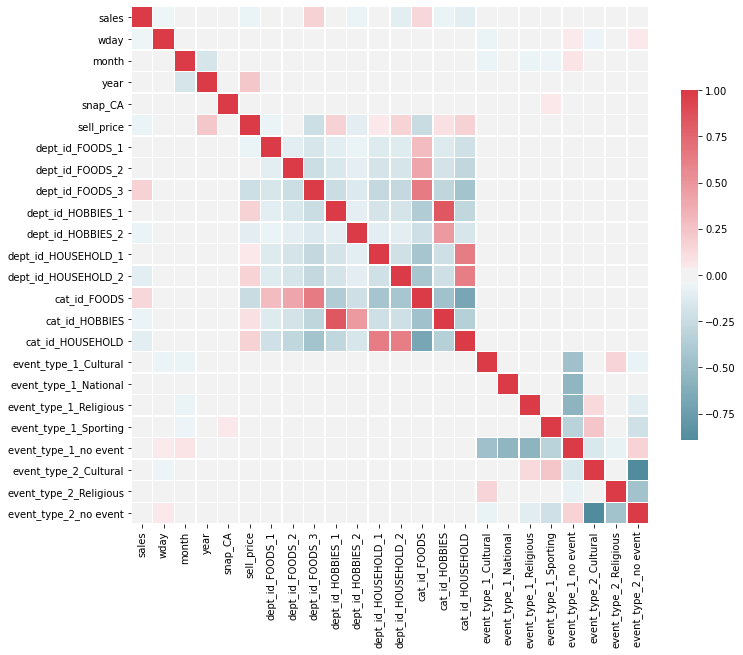

In [13]:
# Generate a mask for the upper triangle
#mask = np.triu(np.ones_like(train_dum.corr(), dtype=np.bool))
#I let the mask here in case someone prefers to apply it, however I see more clear inputs without the mask

plt.figure(figsize=(11, 11))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(df_dumm.corr(), mask=None, cmap=cmap, vmax=1, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.tight_layout()
plt.show()

In [14]:
df_pre = pd.concat([df[["item_id", "d"]], df_dumm], axis=1)

In [15]:
df_pre.drop(columns={"sales", "item_id", "d"})[:"2016-04-25"]

,date,wday,month,year,snap_CA,sell_price,dept_id_FOODS_1,dept_id_FOODS_2,dept_id_FOODS_3,dept_id_HOBBIES_1,dept_id_HOBBIES_2,dept_id_HOUSEHOLD_1,dept_id_HOUSEHOLD_2,cat_id_FOODS,cat_id_HOBBIES,cat_id_HOUSEHOLD,event_type_1_Cultural,event_type_1_National,event_type_1_Religious,event_type_1_Sporting,event_type_1_no event,event_type_2_Cultural,event_type_2_Religious,event_type_2_no event
date_index,,,,,,,,,,,,,,,,,,,,,,,,
2011-01-30,2011-01-30,2,1,2011,0,0.46,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,1
2011-01-30,2011-01-30,2,1,2011,0,0.00,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,1
2011-01-30,2011-01-30,2,1,2011,0,0.00,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,1
2011-01-30,2011-01-30,2,1,2011,0,0.00,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,1
2011-01-30,2011-01-30,2,1,2011,0,0.00,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-04-19,2016-04-19,4,4,2016,0,2.98,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1
2016-04-19,2016-04-19,4,4,2016,0,2.98,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1
2016-04-19,2016-04-19,4,4,2016,0,1.88,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1


In [16]:
#save for later
df_cat = df_pre[["item_id", "d", "date"]]

#ENDOGENEUS VARS
y_train = df_pre[["sales"]][:"2016-04-25"]
y_test = df_pre[["sales"]]["2016-04-25":"2016-05-22"]

In [17]:
from sklearn.preprocessing import StandardScaler
import joblib

ss = StandardScaler()
df_pre_train = df_pre.drop(columns={"sales", "item_id", "d", "date"})[:"2016-04-25"]
with joblib.parallel_backend('dask'):
    x_trans = ss.fit_transform(df_pre_train)

x_train = pd.DataFrame(x_trans)
x_train.columns = df_pre_train.columns
x_train.head()

,wday,month,year,snap_CA,sell_price,dept_id_FOODS_1,dept_id_FOODS_2,dept_id_FOODS_3,dept_id_HOBBIES_1,dept_id_HOBBIES_2,dept_id_HOUSEHOLD_1,dept_id_HOUSEHOLD_2,cat_id_FOODS,cat_id_HOBBIES,cat_id_HOUSEHOLD,event_type_1_Cultural,event_type_1_National,event_type_1_Religious,event_type_1_Sporting,event_type_1_no event,event_type_2_Cultural,event_type_2_Religious,event_type_2_no event
0,-0.998303,-1.548836,-1.441967,-0.700467,-0.881935,-0.276124,-0.387469,-0.608047,2.515815,-0.22667,-0.459742,-0.450817,-0.944161,2.096774,-0.723172,-0.136481,-0.165455,-0.167114,-0.091815,0.295804,-0.039621,-0.022863,0.045763
1,-0.998303,-1.548836,-1.441967,-0.700467,-1.012918,-0.276124,-0.387469,-0.608047,2.515815,-0.22667,-0.459742,-0.450817,-0.944161,2.096774,-0.723172,-0.136481,-0.165455,-0.167114,-0.091815,0.295804,-0.039621,-0.022863,0.045763
2,-0.998303,-1.548836,-1.441967,-0.700467,-1.012918,-0.276124,-0.387469,-0.608047,2.515815,-0.22667,-0.459742,-0.450817,-0.944161,2.096774,-0.723172,-0.136481,-0.165455,-0.167114,-0.091815,0.295804,-0.039621,-0.022863,0.045763
3,-0.998303,-1.548836,-1.441967,-0.700467,-1.012918,-0.276124,-0.387469,-0.608047,2.515815,-0.22667,-0.459742,-0.450817,-0.944161,2.096774,-0.723172,-0.136481,-0.165455,-0.167114,-0.091815,0.295804,-0.039621,-0.022863,0.045763
4,-0.998303,-1.548836,-1.441967,-0.700467,-1.012918,-0.276124,-0.387469,-0.608047,2.515815,-0.22667,-0.459742,-0.450817,-0.944161,2.096774,-0.723172,-0.136481,-0.165455,-0.167114,-0.091815,0.295804,-0.039621,-0.022863,0.045763


In [18]:
df_pre_test = df_pre.drop(columns={"sales", "item_id", "d", "date"})["2016-04-25":"2016-05-22"]
with joblib.parallel_backend('dask'):
    x_test_tr = ss.fit_transform(df_pre_test)
x_test = pd.DataFrame(x_test_tr)
x_test.columns = df_pre_test.columns

In [19]:
from sklearn.ensemble import RandomForestRegressor

rfreg = RandomForestRegressor(n_estimators=500 ,min_samples_split=40, max_features="auto", min_samples_leaf=1, bootstrap=True)

with joblib.parallel_backend('dask'):
    rfreg.fit(x_train, np.ravel(y_train)) 

rfreg_pred = rfreg.predict(x_test)

distributed.core - INFO - Event loop was unresponsive in Worker for 7.03s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Scheduler for 7.03s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 11.70 GB -- Worker memory limit: 16.66 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 11.70 GB -- Worker memory limit: 16.66 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 11.70 GB -- Worker memory limit:

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 11.71 GB -- Worker memory limit: 16.66 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 11.71 GB -- Worker memory limit: 16.66 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 11.71 GB -- Worker memory limit: 16.66 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 11.71 GB -- Worker memory limit: 16.66 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 11.72 GB -- Worker memory limit: 16.66 GB
distributed.wor

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.16 GB -- Worker memory limit: 16.66 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.89 GB -- Worker memory limit: 16.66 GB
distributed.core - INFO - Event loop was unresponsive in Scheduler for 4.14s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Worker for 4.15s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.89 GB -- Worker memory limit:

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 13.49 GB -- Worker memory limit: 16.66 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 13.49 GB -- Worker memory limit: 16.66 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 13.50 GB -- Worker memory limit: 16.66 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 13.50 GB -- Worker memory limit: 16.66 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 13.50 GB -- Worker memory limit: 16.66 GB
distributed.wor

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 13.52 GB -- Worker memory limit: 16.66 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 13.52 GB -- Worker memory limit: 16.66 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 13.52 GB -- Worker memory limit: 16.66 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 13.52 GB -- Worker memory limit: 16.66 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 13.52 GB -- Worker memory limit: 16.66 GB
distributed.wor

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 14.10 GB -- Worker memory limit: 16.66 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 14.10 GB -- Worker memory limit: 16.66 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 14.10 GB -- Worker memory limit: 16.66 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 14.10 GB -- Worker memory limit: 16.66 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 14.10 GB -- Worker memory limit: 16.66 GB
distributed.wor

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 14.11 GB -- Worker memory limit: 16.66 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 14.11 GB -- Worker memory limit: 16.66 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 13.99 GB -- Worker memory limit: 16.66 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 13.99 GB -- Worker memory limit: 16.66 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 13.99 GB -- Worker memory limit: 16.66 GB
distributed.wor

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 14.01 GB -- Worker memory limit: 16.66 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 14.01 GB -- Worker memory limit: 16.66 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 14.01 GB -- Worker memory limit: 16.66 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 14.01 GB -- Worker memory limit: 16.66 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 14.01 GB -- Worker memory limit: 16.66 GB
distributed.wor

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 14.26 GB -- Worker memory limit: 16.66 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 14.26 GB -- Worker memory limit: 16.66 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 14.26 GB -- Worker memory limit: 16.66 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 13.51 GB -- Worker memory limit: 16.66 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 13.55 GB -- Worker memory limit: 16.66 GB
distributed.wor

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 13.55 GB -- Worker memory limit: 16.66 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 13.55 GB -- Worker memory limit: 16.66 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 13.55 GB -- Worker memory limit: 16.66 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 13.55 GB -- Worker memory limit: 16.66 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 13.55 GB -- Worker memory limit: 16.66 GB
distributed.wor

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 13.75 GB -- Worker memory limit: 16.66 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 13.75 GB -- Worker memory limit: 16.66 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 13.75 GB -- Worker memory limit: 16.66 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 13.75 GB -- Worker memory limit: 16.66 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 13.75 GB -- Worker memory limit: 16.66 GB
distributed.wor

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 13.68 GB -- Worker memory limit: 16.66 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 13.68 GB -- Worker memory limit: 16.66 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 13.68 GB -- Worker memory limit: 16.66 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 13.68 GB -- Worker memory limit: 16.66 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 13.68 GB -- Worker memory limit: 16.66 GB
distributed.wor

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 13.61 GB -- Worker memory limit: 16.66 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 13.61 GB -- Worker memory limit: 16.66 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 13.61 GB -- Worker memory limit: 16.66 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 13.61 GB -- Worker memory limit: 16.66 GB
distributed.worker - WARNING - Worker is at 77% memory usage. Resuming worker. Process memory: 12.91 GB -- Worker memory limit: 16.66 GB
distributed.worker - WARNING - Memory use is high but worker has no data to

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 13.80 GB -- Worker memory limit: 16.66 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 13.80 GB -- Worker memory limit: 16.66 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 13.80 GB -- Worker memory limit: 16.66 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 13.80 GB -- Worker memory limit: 16.66 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 13.80 GB -- Worker memory limit: 16.66 GB
distributed.wor

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 13.81 GB -- Worker memory limit: 16.66 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 13.81 GB -- Worker memory limit: 16.66 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 13.81 GB -- Worker memory limit: 16.66 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 13.81 GB -- Worker memory limit: 16.66 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 13.81 GB -- Worker memory limit: 16.66 GB
distributed.wor

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 13.83 GB -- Worker memory limit: 16.66 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 13.83 GB -- Worker memory limit: 16.66 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 13.84 GB -- Worker memory limit: 16.66 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 13.84 GB -- Worker memory limit: 16.66 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 13.84 GB -- Worker memory limit: 16.66 GB
distributed.wor

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 13.86 GB -- Worker memory limit: 16.66 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 13.86 GB -- Worker memory limit: 16.66 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 13.86 GB -- Worker memory limit: 16.66 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 13.86 GB -- Worker memory limit: 16.66 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 13.86 GB -- Worker memory limit: 16.66 GB
distributed.wor

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 13.87 GB -- Worker memory limit: 16.66 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 13.87 GB -- Worker memory limit: 16.66 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 13.87 GB -- Worker memory limit: 16.66 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 13.87 GB -- Worker memory limit: 16.66 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 13.87 GB -- Worker memory limit: 16.66 GB
distributed.wor

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 13.88 GB -- Worker memory limit: 16.66 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 13.88 GB -- Worker memory limit: 16.66 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 13.88 GB -- Worker memory limit: 16.66 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 13.88 GB -- Worker memory limit: 16.66 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 13.88 GB -- Worker memory limit: 16.66 GB
distributed.wor

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 13.89 GB -- Worker memory limit: 16.66 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 13.89 GB -- Worker memory limit: 16.66 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 13.89 GB -- Worker memory limit: 16.66 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 13.89 GB -- Worker memory limit: 16.66 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 13.89 GB -- Worker memory limit: 16.66 GB
distributed.wor

distributed.worker - WARNING - Worker is at 81% memory usage. Pausing worker.  Process memory: 13.62 GB -- Worker memory limit: 16.66 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 13.89 GB -- Worker memory limit: 16.66 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 13.89 GB -- Worker memory limit: 16.66 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 13.89 GB -- Worker memory limit: 16.66 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 13.89 GB -- Worker memory limit: 16.66 GB
distributed.worker - WARNING - Memory use is high but worker has no data to

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 13.92 GB -- Worker memory limit: 16.66 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 13.92 GB -- Worker memory limit: 16.66 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 13.92 GB -- Worker memory limit: 16.66 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 13.92 GB -- Worker memory limit: 16.66 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 13.92 GB -- Worker memory limit: 16.66 GB
distributed.wor

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 13.93 GB -- Worker memory limit: 16.66 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 13.93 GB -- Worker memory limit: 16.66 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 13.93 GB -- Worker memory limit: 16.66 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 13.93 GB -- Worker memory limit: 16.66 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 13.93 GB -- Worker memory limit: 16.66 GB
distributed.wor

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 13.95 GB -- Worker memory limit: 16.66 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 13.95 GB -- Worker memory limit: 16.66 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 13.95 GB -- Worker memory limit: 16.66 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 13.95 GB -- Worker memory limit: 16.66 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 13.95 GB -- Worker memory limit: 16.66 GB
distributed.wor

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 13.81 GB -- Worker memory limit: 16.66 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 13.81 GB -- Worker memory limit: 16.66 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 13.81 GB -- Worker memory limit: 16.66 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 13.81 GB -- Worker memory limit: 16.66 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 13.81 GB -- Worker memory limit: 16.66 GB
distributed.wor

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 14.01 GB -- Worker memory limit: 16.66 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 14.01 GB -- Worker memory limit: 16.66 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 14.01 GB -- Worker memory limit: 16.66 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 14.01 GB -- Worker memory limit: 16.66 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 14.01 GB -- Worker memory limit: 16.66 GB
distributed.wor

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 14.02 GB -- Worker memory limit: 16.66 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 14.02 GB -- Worker memory limit: 16.66 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 14.02 GB -- Worker memory limit: 16.66 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 14.02 GB -- Worker memory limit: 16.66 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 14.02 GB -- Worker memory limit: 16.66 GB
distributed.wor

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 14.02 GB -- Worker memory limit: 16.66 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 14.02 GB -- Worker memory limit: 16.66 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 14.02 GB -- Worker memory limit: 16.66 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 14.02 GB -- Worker memory limit: 16.66 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 14.02 GB -- Worker memory limit: 16.66 GB
distributed.wor

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 14.06 GB -- Worker memory limit: 16.66 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 14.06 GB -- Worker memory limit: 16.66 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 14.06 GB -- Worker memory limit: 16.66 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 14.06 GB -- Worker memory limit: 16.66 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 14.06 GB -- Worker memory limit: 16.66 GB
distributed.wor

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 14.08 GB -- Worker memory limit: 16.66 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 14.08 GB -- Worker memory limit: 16.66 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 14.08 GB -- Worker memory limit: 16.66 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 14.08 GB -- Worker memory limit: 16.66 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 14.08 GB -- Worker memory limit: 16.66 GB
distributed.wor

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 14.09 GB -- Worker memory limit: 16.66 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 14.09 GB -- Worker memory limit: 16.66 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 14.09 GB -- Worker memory limit: 16.66 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 14.09 GB -- Worker memory limit: 16.66 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 14.09 GB -- Worker memory limit: 16.66 GB
distributed.wor

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 13.88 GB -- Worker memory limit: 16.66 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 13.88 GB -- Worker memory limit: 16.66 GB
distributed.worker - WARNING - Worker is at 78% memory usage. Resuming worker. Process memory: 13.13 GB -- Worker memory limit: 16.66 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 13.13 GB -- Worker memory limit: 16.66 GB
distributed.worker - WARNING - Worker is at 82% memory usage. Pausing worker.  Process memory: 13.77 GB -- Worker memory limit: 16.66 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memor

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 13.39 GB -- Worker memory limit: 16.66 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 13.39 GB -- Worker memory limit: 16.66 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 13.39 GB -- Worker memory limit: 16.66 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 13.40 GB -- Worker memory limit: 16.66 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 13.40 GB -- Worker memory limit: 16.66 GB
distributed.wor

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 13.41 GB -- Worker memory limit: 16.66 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 13.41 GB -- Worker memory limit: 16.66 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 13.41 GB -- Worker memory limit: 16.66 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 13.41 GB -- Worker memory limit: 16.66 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 13.41 GB -- Worker memory limit: 16.66 GB
distributed.wor

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 13.42 GB -- Worker memory limit: 16.66 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 13.42 GB -- Worker memory limit: 16.66 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 13.34 GB -- Worker memory limit: 16.66 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 13.34 GB -- Worker memory limit: 16.66 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 13.34 GB -- Worker memory limit: 16.66 GB
distributed.wor

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 13.54 GB -- Worker memory limit: 16.66 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 13.54 GB -- Worker memory limit: 16.66 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 13.54 GB -- Worker memory limit: 16.66 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 13.54 GB -- Worker memory limit: 16.66 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 13.54 GB -- Worker memory limit: 16.66 GB
distributed.wor

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 13.55 GB -- Worker memory limit: 16.66 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 13.55 GB -- Worker memory limit: 16.66 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 13.55 GB -- Worker memory limit: 16.66 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 13.55 GB -- Worker memory limit: 16.66 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 13.55 GB -- Worker memory limit: 16.66 GB
distributed.wor

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 13.55 GB -- Worker memory limit: 16.66 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 13.55 GB -- Worker memory limit: 16.66 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 13.39 GB -- Worker memory limit: 16.66 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 13.39 GB -- Worker memory limit: 16.66 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 13.39 GB -- Worker memory limit: 16.66 GB
distributed.wor

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 14.24 GB -- Worker memory limit: 16.66 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 14.24 GB -- Worker memory limit: 16.66 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 14.24 GB -- Worker memory limit: 16.66 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 14.24 GB -- Worker memory limit: 16.66 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 14.24 GB -- Worker memory limit: 16.66 GB
distributed.wor

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 14.25 GB -- Worker memory limit: 16.66 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 14.25 GB -- Worker memory limit: 16.66 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 14.25 GB -- Worker memory limit: 16.66 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 14.26 GB -- Worker memory limit: 16.66 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 14.26 GB -- Worker memory limit: 16.66 GB
distributed.wor

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 14.28 GB -- Worker memory limit: 16.66 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 14.28 GB -- Worker memory limit: 16.66 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 14.28 GB -- Worker memory limit: 16.66 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 14.28 GB -- Worker memory limit: 16.66 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 14.28 GB -- Worker memory limit: 16.66 GB
distributed.wor

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 14.29 GB -- Worker memory limit: 16.66 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 14.29 GB -- Worker memory limit: 16.66 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 14.29 GB -- Worker memory limit: 16.66 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 14.29 GB -- Worker memory limit: 16.66 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 14.29 GB -- Worker memory limit: 16.66 GB
distributed.wor

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 13.35 GB -- Worker memory limit: 16.66 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 13.35 GB -- Worker memory limit: 16.66 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 13.35 GB -- Worker memory limit: 16.66 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 13.35 GB -- Worker memory limit: 16.66 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 13.35 GB -- Worker memory limit: 16.66 GB
distributed.wor

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 13.35 GB -- Worker memory limit: 16.66 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 13.35 GB -- Worker memory limit: 16.66 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 13.35 GB -- Worker memory limit: 16.66 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 13.35 GB -- Worker memory limit: 16.66 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 13.35 GB -- Worker memory limit: 16.66 GB
distributed.wor

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 13.73 GB -- Worker memory limit: 16.66 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 13.73 GB -- Worker memory limit: 16.66 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 13.73 GB -- Worker memory limit: 16.66 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 13.73 GB -- Worker memory limit: 16.66 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 13.73 GB -- Worker memory limit: 16.66 GB
distributed.wor

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 13.73 GB -- Worker memory limit: 16.66 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 13.73 GB -- Worker memory limit: 16.66 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 13.73 GB -- Worker memory limit: 16.66 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 13.73 GB -- Worker memory limit: 16.66 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 13.73 GB -- Worker memory limit: 16.66 GB
distributed.wor

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 13.73 GB -- Worker memory limit: 16.66 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 13.73 GB -- Worker memory limit: 16.66 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 13.73 GB -- Worker memory limit: 16.66 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 13.73 GB -- Worker memory limit: 16.66 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 13.73 GB -- Worker memory limit: 16.66 GB
distributed.wor

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 13.73 GB -- Worker memory limit: 16.66 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 13.73 GB -- Worker memory limit: 16.66 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 13.73 GB -- Worker memory limit: 16.66 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 13.73 GB -- Worker memory limit: 16.66 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 13.73 GB -- Worker memory limit: 16.66 GB
distributed.wor

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 13.74 GB -- Worker memory limit: 16.66 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 13.74 GB -- Worker memory limit: 16.66 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 13.74 GB -- Worker memory limit: 16.66 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 13.74 GB -- Worker memory limit: 16.66 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 13.74 GB -- Worker memory limit: 16.66 GB
distributed.wor

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 13.79 GB -- Worker memory limit: 16.66 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 13.79 GB -- Worker memory limit: 16.66 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 13.79 GB -- Worker memory limit: 16.66 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 13.79 GB -- Worker memory limit: 16.66 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 13.79 GB -- Worker memory limit: 16.66 GB
distributed.wor

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 13.56 GB -- Worker memory limit: 16.66 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 13.56 GB -- Worker memory limit: 16.66 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 13.56 GB -- Worker memory limit: 16.66 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 13.56 GB -- Worker memory limit: 16.66 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 13.56 GB -- Worker memory limit: 16.66 GB
distributed.wor

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 13.80 GB -- Worker memory limit: 16.66 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 13.80 GB -- Worker memory limit: 16.66 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 13.80 GB -- Worker memory limit: 16.66 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 13.80 GB -- Worker memory limit: 16.66 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 13.80 GB -- Worker memory limit: 16.66 GB
distributed.wor

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 13.80 GB -- Worker memory limit: 16.66 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 13.80 GB -- Worker memory limit: 16.66 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 13.80 GB -- Worker memory limit: 16.66 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 13.80 GB -- Worker memory limit: 16.66 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 13.80 GB -- Worker memory limit: 16.66 GB
distributed.wor

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 13.80 GB -- Worker memory limit: 16.66 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 13.80 GB -- Worker memory limit: 16.66 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 13.80 GB -- Worker memory limit: 16.66 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 13.80 GB -- Worker memory limit: 16.66 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 13.80 GB -- Worker memory limit: 16.66 GB
distributed.wor

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 13.81 GB -- Worker memory limit: 16.66 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 13.81 GB -- Worker memory limit: 16.66 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 13.81 GB -- Worker memory limit: 16.66 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 13.81 GB -- Worker memory limit: 16.66 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 13.81 GB -- Worker memory limit: 16.66 GB
distributed.wor

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 13.81 GB -- Worker memory limit: 16.66 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 13.81 GB -- Worker memory limit: 16.66 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 13.81 GB -- Worker memory limit: 16.66 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 13.81 GB -- Worker memory limit: 16.66 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 13.81 GB -- Worker memory limit: 16.66 GB
distributed.wor

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 13.85 GB -- Worker memory limit: 16.66 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 13.86 GB -- Worker memory limit: 16.66 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 13.86 GB -- Worker memory limit: 16.66 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 13.86 GB -- Worker memory limit: 16.66 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 13.86 GB -- Worker memory limit: 16.66 GB
distributed.wor

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 13.74 GB -- Worker memory limit: 16.66 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 13.74 GB -- Worker memory limit: 16.66 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 13.75 GB -- Worker memory limit: 16.66 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 13.75 GB -- Worker memory limit: 16.66 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 13.75 GB -- Worker memory limit: 16.66 GB
distributed.wor

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 14.08 GB -- Worker memory limit: 16.66 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 14.08 GB -- Worker memory limit: 16.66 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 14.08 GB -- Worker memory limit: 16.66 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 14.08 GB -- Worker memory limit: 16.66 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 14.08 GB -- Worker memory limit: 16.66 GB
distributed.wor

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 14.08 GB -- Worker memory limit: 16.66 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 14.08 GB -- Worker memory limit: 16.66 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 14.08 GB -- Worker memory limit: 16.66 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 14.08 GB -- Worker memory limit: 16.66 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 14.08 GB -- Worker memory limit: 16.66 GB
distributed.wor

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 14.08 GB -- Worker memory limit: 16.66 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 14.08 GB -- Worker memory limit: 16.66 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 14.08 GB -- Worker memory limit: 16.66 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 14.08 GB -- Worker memory limit: 16.66 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 14.08 GB -- Worker memory limit: 16.66 GB
distributed.wor

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 14.09 GB -- Worker memory limit: 16.66 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 14.09 GB -- Worker memory limit: 16.66 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 14.09 GB -- Worker memory limit: 16.66 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 14.09 GB -- Worker memory limit: 16.66 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 14.09 GB -- Worker memory limit: 16.66 GB
distributed.wor

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 14.09 GB -- Worker memory limit: 16.66 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 14.09 GB -- Worker memory limit: 16.66 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 14.09 GB -- Worker memory limit: 16.66 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 14.09 GB -- Worker memory limit: 16.66 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 14.09 GB -- Worker memory limit: 16.66 GB
distributed.wor

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 14.12 GB -- Worker memory limit: 16.66 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 14.12 GB -- Worker memory limit: 16.66 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 14.13 GB -- Worker memory limit: 16.66 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 14.14 GB -- Worker memory limit: 16.66 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 14.14 GB -- Worker memory limit: 16.66 GB
distributed.wor

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 14.17 GB -- Worker memory limit: 16.66 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 14.17 GB -- Worker memory limit: 16.66 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 14.17 GB -- Worker memory limit: 16.66 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 14.17 GB -- Worker memory limit: 16.66 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 14.17 GB -- Worker memory limit: 16.66 GB
distributed.wor

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 14.18 GB -- Worker memory limit: 16.66 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 14.18 GB -- Worker memory limit: 16.66 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 14.18 GB -- Worker memory limit: 16.66 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 14.18 GB -- Worker memory limit: 16.66 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 14.11 GB -- Worker memory limit: 16.66 GB
distributed.wor

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 13.35 GB -- Worker memory limit: 16.66 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 13.35 GB -- Worker memory limit: 16.66 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 13.35 GB -- Worker memory limit: 16.66 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 13.35 GB -- Worker memory limit: 16.66 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 13.35 GB -- Worker memory limit: 16.66 GB
distributed.wor

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 13.35 GB -- Worker memory limit: 16.66 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 13.35 GB -- Worker memory limit: 16.66 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 13.35 GB -- Worker memory limit: 16.66 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 13.35 GB -- Worker memory limit: 16.66 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 13.35 GB -- Worker memory limit: 16.66 GB
distributed.wor

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 13.35 GB -- Worker memory limit: 16.66 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 13.35 GB -- Worker memory limit: 16.66 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 13.35 GB -- Worker memory limit: 16.66 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 13.35 GB -- Worker memory limit: 16.66 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 13.35 GB -- Worker memory limit: 16.66 GB
distributed.wor

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 13.38 GB -- Worker memory limit: 16.66 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 13.38 GB -- Worker memory limit: 16.66 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 13.38 GB -- Worker memory limit: 16.66 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 13.38 GB -- Worker memory limit: 16.66 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 13.38 GB -- Worker memory limit: 16.66 GB
distributed.wor

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 13.07 GB -- Worker memory limit: 16.66 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 13.07 GB -- Worker memory limit: 16.66 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 13.07 GB -- Worker memory limit: 16.66 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 13.07 GB -- Worker memory limit: 16.66 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 13.07 GB -- Worker memory limit: 16.66 GB
distributed.wor

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 11.69 GB -- Worker memory limit: 16.66 GB


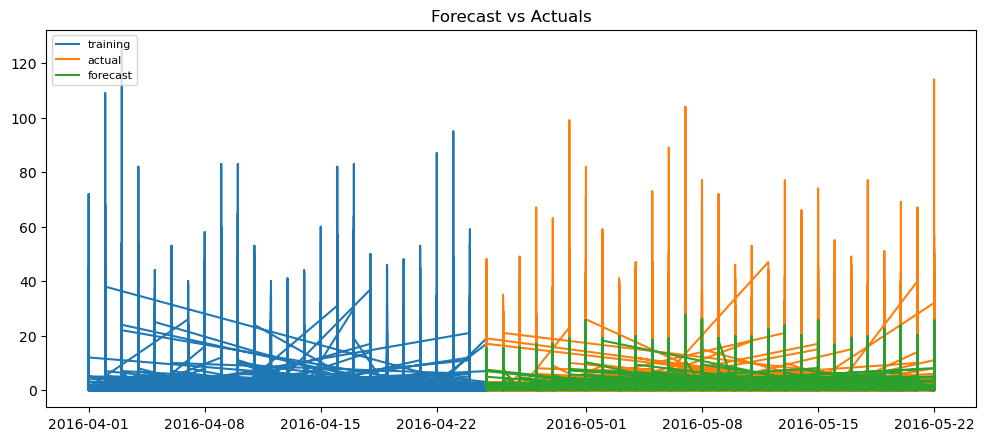

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 11.70 GB -- Worker memory limit: 16.66 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 11.70 GB -- Worker memory limit: 16.66 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 11.70 GB -- Worker memory limit: 16.66 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 11.70 GB -- Worker memory limit: 16.66 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 11.70 GB -- Worker memory limit: 16.66 GB
distributed.wor

In [36]:
warnings.filterwarnings("default")

plt.figure(figsize=(12,5), dpi=100)
plt.plot(y_train["2016-04":], label='training')
plt.plot(y_test, label='actual')
plt.plot(pd.DataFrame(rfreg_pred, index=y_test.index), label='forecast')
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()